In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import email
import string
from bs4 import BeautifulSoup
import string
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import os
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve 
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import roc_curve
import os
import warnings
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score

In [2]:
easy_ham_path = './data/easy_ham/easy_ham/'
hard_ham_path = './data/hard_ham/hard_ham/'
spam_path = './data/spam_2/spam_2/'

test_spam_path = './data/test/spam/'
test_ham_path = './data/test/ham/'

In [3]:
def get_data(path):
    data = []
    files = os.listdir(path)
    for file in files:
        f = open(path+file, encoding = "ISO-8859-1")
        words_list = f.read()
        data.append(words_list)
        f.close()
    return data

In [4]:
easy_ham = get_data(easy_ham_path)
hard_ham = get_data(hard_ham_path)
ham = easy_ham + hard_ham
spam = get_data(spam_path)

test_spam = get_data(test_spam_path)
test_ham = get_data(test_ham_path)

In [5]:
np.random.shuffle(ham)
np.random.shuffle(spam)

np.random.shuffle(test_spam)
np.random.shuffle(test_ham)

In [6]:
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
class email_to_clean_text(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    def fit(self, X, y=None): 
        return self
    def transform(self, X):
        text_list = []
        for mail in X:
            b = email.message_from_string(mail)
            body = ""
            if b.is_multipart():
                for part in b.walk():
                    ctype = part.get_content_type()
                    cdispo = str(part.get('Content-Disposition'))
                    if ctype == 'text/plain' and 'attachment' not in cdispo:
                        body = part.get_payload(decode=True)  # боди
                        break
            else:
                body = b.get_payload(decode=True) # получаем боди
            soup = BeautifulSoup(body, "html.parser") #получаем текст из боди
            text = soup.get_text().lower()
            text = re.sub(r'(https|http)?:\/\/(\w|\.|\/|\?|\=|\&|\%)*\b', '', text, flags=re.MULTILINE) #удаляем ссылки
            text = re.sub(r'\b[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Z|a-z]{2,}\b', '', text, flags=re.MULTILINE) #удалить мыло
            text = text.translate(str.maketrans('', '', string.punctuation)) # удалить пунктуацию
            text = ''.join([i for i in text if not i.isdigit()]) # удалить цифры
            stop_words = stopwords.words('english')
            words_list = [w for w in text.split() if w not in stop_words] # стоп слова из списка nltk
            words_list = [lemmatizer.lemmatize(w) for w in words_list] #лемматизация
            words_list = [stemmer.stem(w) for w in words_list] #стемминг
            text_list.append(' '.join(words_list))
        return text_list

In [7]:
email_to_text = email_to_clean_text()

In [8]:
text_ham = email_to_text.transform(ham)
text_spam = email_to_text.transform(spam)

text_test_spam = email_to_text.transform(test_spam)
text_test_ham = email_to_text.transform(test_ham)

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.
Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


In [9]:
y = len(text_ham)*[0] + len(text_spam)*[1]

test_set = len(text_test_ham)*[0] + len(text_test_spam)*[1]

all_test_data = text_test_ham + text_test_spam

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(text_ham+text_spam, y,
                                                    stratify=y, 
                                                    test_size=0.2)

In [11]:
vectorizer = CountVectorizer(stop_words='english')
vectorizer.fit(X_train)


CountVectorizer(stop_words='english')

In [12]:
vectorizer.fit(all_test_data)

CountVectorizer(stop_words='english')

In [13]:
X_train = vectorizer.transform(X_train).toarray()
y_train = np.array(y_train).reshape(len(y_train), 1)

In [14]:
X_test = vectorizer.transform(X_test).toarray()
y_test = np.array(y_test).reshape(len(y_test), 1)

In [15]:
all_test_data = vectorizer.transform(all_test_data).toarray()

In [16]:
rfc = RandomForestClassifier(n_estimators=1200)
rfc.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1200)

In [17]:
predictions = rfc.predict(all_test_data)

In [30]:


print('Metrics for model')
print('Accuracy: {:.2f}%'.format(accuracy_score(test_set,predictions)*100))
print('Precision: {:.2f}%'.format(precision_score(test_set,predictions)*100))
print('Recall: {:.2f}%'.format(recall_score(test_set,predictions)*100))
print('F1 score: {:.2f}%'.format(f1_score(test_set,predictions)*100))

Metrics for model
Accuracy: 95.06%
Precision: 98.02%
Recall: 94.00%
F1 score: 95.97%


In [21]:
conf_mx = confusion_matrix(test_set, predictions)

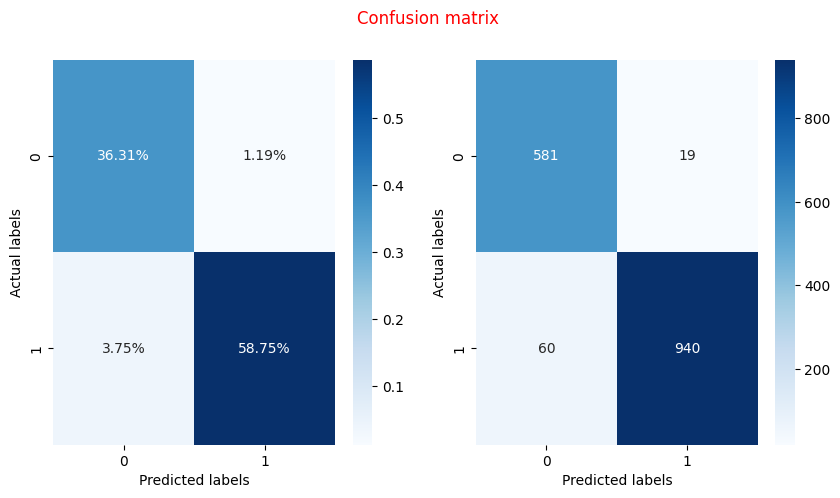

In [22]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10,5))
fig.suptitle('Confusion matrix', c='r')
sns.heatmap(conf_mx/np.sum(conf_mx), ax=axes[0], annot=True, 
            fmt='.2%', cmap='Blues')
axes[0].set_xlabel('Predicted labels')
axes[0].set_ylabel('Actual labels')

sns.heatmap(conf_mx, ax=axes[1], annot=True, cmap='Blues', fmt='')
axes[1].set_xlabel('Predicted labels')
axes[1].set_ylabel('Actual labels')
plt.show()

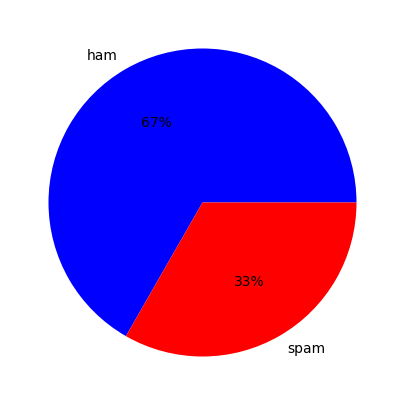

In [26]:
data = [len(ham)/len(ham+spam), len(spam)/len(ham+spam)]
labels = ['ham', 'spam']
colors = ['blue', 'red']
plt.figure(figsize=(12, 5))
plt.pie(data, labels = labels, autopct='%.0f%%', colors=colors)
plt.show()